In [1]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For tesxt:
import re

# For times:
import time

# Set a random seed for imputation
#  Source:  https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
np.random.seed(42)

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder


# Read in Data

In [21]:
lstn = pd.read_csv('../data/prepped_training.csv')

In [42]:
# The code below will aggregate the correlation coefficients between all columns which are not
#  price and log_price vs. price and log price

# This code using dictionaries was written with the help of the following sourece:
#  https://www.guru99.com/python-dictionary-append.html
corr_dict = {'name': [], 'price_corr':[], 'log_price_corr': [], 'magnitude': [], 'which': []}

# Get a list of all the columns to iterate through, remvoe price and log_price
col_list = list(lstn.columns)
col_list.remove('price')
col_list.remove('log_price')

# This loop creates data for each column
for col in col_list:
    
    # Find correlations to price and log_price
    p_corr = np.corrcoef(lstn[col], lstn['price'])[0][1]
    lp_corr = np.corrcoef(lstn[col], lstn['log_price'])[0][1]
    
    # Repor the higher magnitude value
    mag = max(abs(p_corr), abs(lp_corr))
    
    # Append the above data to the dictionary
    corr_dict['name'].append(col)
    corr_dict['price_corr'].append(p_corr)
    corr_dict['log_price_corr'].append(lp_corr)
    corr_dict['magnitude'].append(mag)
    
    # The if statement below will print which correaltion is stronger
    if abs(p_corr) > abs(lp_corr):
        corr_dict['which'].append('price')
    
    else:
        corr_dict['which'].append('log_price')

# Create a dataframe from the dictionary
corr_df = pd.DataFrame(corr_dict)

In [44]:
corr_df.head()

,name,price_corr,log_price_corr,magnitude,which
0,host_since,0.039550,0.027396,0.039550,price
1,host_response_rate,-0.003495,0.041759,0.041759,log_price
2,host_acceptance_rate,0.130797,0.271477,0.271477,log_price
3,host_listings_count,0.016601,0.136672,0.136672,log_price
4,host_total_listings_count,-0.011012,0.082024,0.082024,log_price


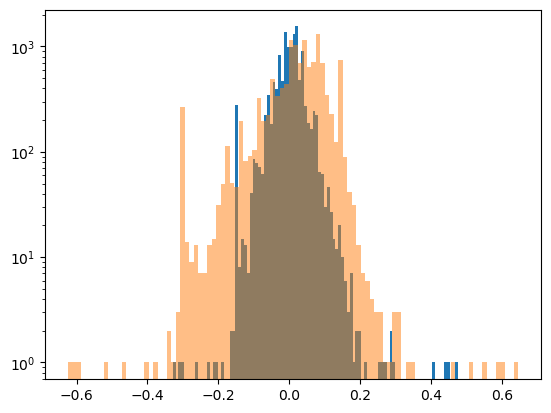

In [45]:
# Plot an overlapping histogram of the correlation distributions
plt.hist(corr_df.price_corr, bins = 100)
plt.hist(corr_df.log_price_corr, bins = 100, alpha = 0.5)
plt.yscale('log')
plt.show();

In [52]:
'''
PSEUDO CODE:

Want to avoid having both log_col and col in the list of top features.

So have it loop through starting at the larget magnitude going towards the smallest
and have it check to see if:
1.  log_{col} in list of cols
    OR...
2.  col.replace('log_') in list of cols (this would need to be a try except)

...then, don't include it.

'''

best_corrs = corr_df[corr_df['magnitude'] > 0.3]
best_corrs.sort_values(by = 'magnitude', ascending=False)

,name,price_corr,log_price_corr,magnitude,which
33,log_accommodates,0.437727,0.647343,0.647343,log_price
125,room_type_Private room,-0.328703,-0.625225,0.625225,log_price
25,pcnt_private,-0.310895,-0.605388,0.605388,log_price
24,pcnt_ent_homes,0.292924,0.598974,0.598974,log_price
51,log_pcnt_private,-0.297661,-0.590685,0.590685,log_price
7,accommodates,0.477002,0.588747,0.588747,log_price
50,log_pcnt_ent_homes,0.264138,0.551693,0.551693,log_price
112,property_type_Private room in rental unit,-0.258554,-0.519602,0.519602,log_price
35,log_beds,0.405373,0.516437,0.516437,log_price
9,beds,0.448116,0.465801,0.465801,log_price
